In [1]:
# load data from csv file and save data into separate lists
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.fftpack import fft, ifft
from sklearn.decomposition import PCA
import warnings
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
import pickle

In [2]:
# when read the data from CSV, the time stamp and associated GMC value should be reversed
def read_raw_data():
    x_1 =[]
    x_2 =[]

    for i in range (5):
        x_1=[]
        x_2=[]
        with open(r'.\mealData'+str(i+1)+'.csv','rt')as f:
            data = csv.reader(f)
            rows_x=[row for idx, row in enumerate(data) if idx<50]# only use first 20 rows of the data
            for row in rows_x:
                x_1.append(row)
        with open(r'.\MealAmountData'+str(i+1)+'.csv','rt')as ff:
            data = csv.reader(ff)
            rows_x=[row for idx, row in enumerate(data) if idx<50]# only use first 20 rows of the data
            for row in rows_x:
                x_2.append(row)
        if i==0:
            x1 = x_1
            x2 = x_2
        elif i!=0:
            x1 = x1+x_1
            x2 = x2+x_2
    return x1,x2

# this func is used to remove the data which contains 'NaN' and only use the first 30 data
def smooth_data(y,x):
    idx = []
    size_y = len(y)
    for i in range (size_y):
        y[i] = y[i][:30]
        y[i] = y[i][::-1]
        if (len(y[i])!= 30):
            idx.append(i)
        elif 'NaN' in y[i]:
            idx.append(i)      
    for j in range (len(idx),0,-1):
        del y[idx[j-1]]
        del x[idx[j-1]]
    return y, x

In [3]:
x1,x2 = read_raw_data()
print('Number of rows from meal data:',len(x1))
print('Number of meal amount data:',len(x2))

x1, x2 = smooth_data(x1, x2)
print("Number of rows from the processed meal data: ",len(x1) )
print("Number of rows from the processed meal amount data: ",len(x2))

Number of rows from meal data: 250
Number of meal amount data: 250
Number of rows from the processed meal data:  211
Number of rows from the processed meal amount data:  211


In [4]:
def extract_ground_truth(x2):
    bin_truth = []
    for i in range (len(x2)):
        if int(x2[i][0]) == 0:
            bin_truth.append(1)
        elif (int(x2[i][0])>0) and (int(x2[i][0])<=20):
            bin_truth.append(2)
        elif (int(x2[i][0])>20) and (int(x2[i][0])<=40):
            bin_truth.append(3)
        elif (int(x2[i][0])>40) and (int(x2[i][0])<=60):
            bin_truth.append(4)
        elif (int(x2[i][0])>60) and (int(x2[i][0])<=80):
            bin_truth.append(5)
        elif (int(x2[i][0])>80) and (int(x2[i][0])<=100):
            bin_truth.append(6)
    return bin_truth  

In [5]:
bin_truth = extract_ground_truth(x2)
print("number of points in Bin 1",bin_truth.count(1))
print("number of points in Bin 2",bin_truth.count(2))
print("number of points in Bin 3",bin_truth.count(3))
print("number of points in Bin 4",bin_truth.count(4))
print("number of points in Bin 5",bin_truth.count(5))
print("number of points in Bin 6",bin_truth.count(6))

number of points in Bin 1 56
number of points in Bin 2 45
number of points in Bin 3 29
number of points in Bin 4 55
number of points in Bin 5 19
number of points in Bin 6 7


In [6]:
# function for calculating the avg of changing velocity with window size 3, result in 10 features
def avg_vel(y):
    average = sum(y)/len(y)
    vel_y = []
    avg_vel = []
    window_size = 3
    for i in range (len(y)-1):
        vel = y[i+1]-y[i]
        vel_y.append(vel)
    np.asarray(vel_y)

    for i in range (int(len(y)/window_size)):
        if i != (int((len(y)/window_size)-1)):
            avg = np.average(vel_y[(i*3):(i*3)+3])
        avg_vel.append(avg)
    array_vel = np.asarray(avg_vel)
    array_vel = normalize(array_vel[:,np.newaxis], axis=0).ravel()
#     array_vel = (array_vel - min(array_vel))/(max(array_vel)-min(array_vel))
    return array_vel

# function for calculating the avg of meal amount with window size 3, result in 10 features
def avg_win(y):
    avg_win = []
    window_size = 3
    for i in range (int(len(y)/window_size)):
        if i != (int((len(y)/window_size)-1)):
            avg = np.average(y[(i*3):(i*3)+3])
        avg_win.append(avg)
    array_win = np.asarray(avg_win)
    array_win = normalize(array_win[:,np.newaxis], axis=0).ravel()
#     array_vel = (array_vel - min(array_vel))/(max(array_vel)-min(array_vel))
    return array_win

def max_increase(y):
    change = []
    y = list(map(int, y))
    y_0 = y[5]
    y_max = max(y[5:])
    y_end = y[29]
    max_increase = (y_max - y_0)/y_0
    max_decrease = (y_max - y_end)/y_end
    before_change = max(y[:5])-min(y[:5])
    change.append(max_increase)
    change.append(max_decrease)
    change.append(before_change)
    change = np.asarray(change,dtype=np.float32)
    changed = normalize(change[:,np.newaxis], axis=0).ravel()
#     changed = (change-min(change))/(max(change)-min(change))
    return changed

In [7]:
array_x = np.asarray(x1[2],dtype=int)
cc = avg_vel(array_x)
print(cc)
dd = max_increase(array_x)
print(dd)
ee = avg_win(array_x)
print(ee)

[-0.06823118 -0.04093871  0.02729247  0.40938706  0.66866553  0.57314188
  0.04093871 -0.05458494  0.15010859  0.15010859]
[0.23715839 0.         0.971471  ]
[0.17256348 0.1636614  0.16092229 0.17324826 0.26021477 0.3553986
 0.41634364 0.40675678 0.42113707 0.42113707]


In [8]:
# extract feature and save it into feature metricx
for i in range(len(x1)):
    yy = np.asarray(x1[i],dtype=np.float32)
    f1 = avg_vel(yy)
    f2 = max_increase(yy)
    f1 = np.concatenate((f1, f2), axis=None)
#     f3 = avg_win(yy)
#     f1 = np.concatenate((f12, f3), axis=None)
    if i == 0:
        feature_m1 = f1
    else:
        feature_m1 = np.vstack((feature_m1,f1))

In [9]:
print(feature_m1)

[[ 0.22011779  0.64342123  0.33864275 ...  0.01708368  0.02572302
   0.99952304]
 [-0.01279635  0.2687233   0.21753791 ...  0.13975823  0.9273988
   0.34698594]
 [-0.06823117 -0.04093871  0.02729247 ...  0.23715839  0.
   0.971471  ]
 ...
 [ 0.14610927 -0.5977197  -0.5445891  ...  0.          0.07047059
   0.9975139 ]
 [-0.06292918 -0.23913091 -0.28947425 ...  0.          0.08656408
   0.9962463 ]
 [-0.07015745  0.08185035  0.19877942 ...  0.1998337   0.
   0.9798298 ]]


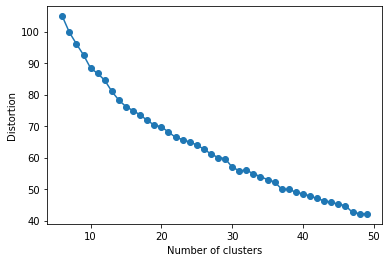

In [86]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(6, 50):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(feature_m1)
    distortions.append(km.inertia_)

# plot
plt.plot(range(6, 50), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

kmeans = KMeans(n_clusters=37, random_state=0).fit(feature_m1)
label = kmeans.labels_
label = list(label)
n_cluster = 37
idx_keep = [i for i in range (len(label))]
def try_model_kmeans(label,feature_m1,n_cluster,idx_keep):
    cluster = []
    bin_cluster = []
    bin_index = []
    result = []
    bin_1 = []
    bin_2 = []
    bin_3 = []
    bin_4 = []
    bin_5 = []
    bin_6 = []
    bin_1_idx = []
    bin_2_idx = []
    bin_3_idx = []
    bin_4_idx = []
    bin_5_idx = []
    bin_6_idx = []
    idx_save = []
    for j in range (n_cluster):
        cluster_j = [ i for i in range(len(label)) if label[i] == j ]
        idx_save_j = [idx_keep[i] for i in cluster_j]
                
        cluster.append(cluster_j)
        idx_save.append(idx_save_j)
    for j in range (n_cluster):
        result_label = [bin_truth[i] for i in cluster[j]]
#         print(max(set(result_label), key=result_label.count), " ", len(result_label))
        result.append(max(set(result_label), key=result_label.count))
    for k in range (n_cluster):
        if result[k]==1:
            bin_1 = bin_1 + cluster[k]
            bin_1_idx = bin_1_idx + idx_save[k]
        elif result[k]==2:
            bin_2 = bin_2 + cluster[k]
            bin_2_idx = bin_2_idx + idx_save[k]
        elif result[k]==3:
            bin_3 = bin_3 + cluster[k]
            bin_3_idx = bin_3_idx + idx_save[k]
        elif result[k]==4:
            bin_4 = bin_4 + cluster[k]
            bin_4_idx = bin_4_idx + idx_save[k]
        elif result[k]==5:
            bin_5 = bin_5 + cluster[k]
            bin_5_idx = bin_5_idx + idx_save[k]
        elif result[k]==6:
            bin_6 = bin_6 + cluster[k]
            bin_6_idx = bin_6_idx + idx_save[k]
    bin_cluster.append(bin_1)
    bin_cluster.append(bin_2)
    bin_cluster.append(bin_3)
    bin_cluster.append(bin_4)
    bin_cluster.append(bin_5)
    bin_cluster.append(bin_6)
    bin_index.append(bin_1_idx)
    bin_index.append(bin_2_idx)
    bin_index.append(bin_3_idx)
    bin_index.append(bin_4_idx)
    bin_index.append(bin_5_idx)
    bin_index.append(bin_6_idx)
    return bin_cluster, bin_index

In [87]:
bin_cluster, bin_index = try_model_kmeans(label,feature_m1,n_cluster,idx_keep)

In [106]:
print("1-st Kmeans result:")
print("Bin","Num")
for i in range (6):
    print(i+1, " ", len(bin_cluster[i]))

print("########## Tree Height = 2 ############")
f1 = [feature_m1[i] for i in bin_cluster[0]]
bin_index_1 = bin_index[0]
kmeans_1 = KMeans(n_clusters=23, random_state=0).fit(f1)
label_1 = list(kmeans_1.labels_)
bin_cluster_2nd, bin_index_2nd = try_model_kmeans(label_1,f1,23,bin_index_1)
print("2-nd Kmeans result:")
print("Bin","Num")
for i in range (6):
    print(i+1, " ", len(bin_cluster_2nd[i]))
    
f2 = [feature_m1[i] for i in bin_cluster[3]]
bin_index_2 = bin_index[3]
kmeans_2 = KMeans(n_clusters=6, random_state=0).fit(f2)
label_2 = list(kmeans_2.labels_)
bin_cluster_3rd, bin_index_3rd = try_model_kmeans(label_2,f2,6,bin_index_2)
print("3-rd Kmeans result:")
print("Bin","Num")
for i in range (6):
    print(i+1, " ", len(bin_cluster_3rd[i]))

    
# f3 = [feature_m1[i] for i in bin_cluster[3]]
# kmeans_3 = KMeans(n_clusters=10, random_state=0).fit(f3)
# label_3 = list(kmeans_3.labels_)
# bin_cluster_4th = try_model_kmeans(label_3,f3,10)
# print("4-th Kmeans result:")
# print("Bin","Num")
# for i in range (6):
#     print(i+1, " ", len(bin_cluster_4th[i]))
    
# print("########## Tree Height = 3 ############")
# f3 = [feature_m1[i] for i in bin_cluster_2nd[0]]
# kmeans_3 = KMeans(n_clusters=6, random_state=0).fit(f3)
# label_3 = list(kmeans_3.labels_)
# bin_cluster_4th = try_model_kmeans(label_3,f3,6)
# print("4-th Kmeans result:")
# print("Bin","Num")
# for i in range (6):
#     print(i+1, " ", len(bin_cluster_4th[i]))
    

# f4 = [feature_m1[i] for i in bin_cluster_2nd[4]]
# kmeans_4 = KMeans(n_clusters=6, random_state=0).fit(f4)
# label_4 = list(kmeans_4.labels_)
# bin_cluster_5th = try_model_kmeans(label_4,f4,6)
# print("5-th Kmeans result:")
# print("Bin","Num")
# for i in range (6):
#     print(i+1, " ", len(bin_cluster_5th[i]))

1-st Kmeans result:
Bin Num
1   103
2   37
3   5
4   52
5   14
6   0
########## Tree Height = 2 ############
2-nd Kmeans result:
Bin Num
1   51
2   21
3   0
4   20
5   6
6   5
3-rd Kmeans result:
Bin Num
1   21
2   4
3   10
4   17
5   0
6   0


In [107]:
final_result = [0]*len(feature_m1)
final_bin1 = bin_index_2nd[0]+bin_index_3rd[0]
final_bin2 = bin_index[1]+bin_index_2nd[1]+bin_index_3rd[1]
final_bin3 = bin_index[2]+bin_index_2nd[2]+bin_index_3rd[2]
final_bin4 = bin_index_2nd[3]+bin_index_3rd[3]
final_bin5 = bin_index[4]+bin_index_2nd[4]+bin_index_3rd[4]
final_bin6 = bin_index[5]+bin_index_2nd[5]+bin_index_3rd[5]
label_bin1 = [1]*len(final_bin1)
label_bin2 = [2]*len(final_bin2)
label_bin3 = [3]*len(final_bin3)
label_bin4 = [4]*len(final_bin4)
label_bin5 = [5]*len(final_bin5)
label_bin6 = [6]*len(final_bin6)


for (i, j) in zip(final_bin1, label_bin1):
    final_result[i] = j
    
for (i, j) in zip(final_bin2, label_bin2):
    final_result[i] = j
    
for (i, j) in zip(final_bin3, label_bin3):
    final_result[i] = j
    
for (i, j) in zip(final_bin4, label_bin4):
    final_result[i] = j
    
for (i, j) in zip(final_bin5, label_bin5):
    final_result[i] = j
    
for (i, j) in zip(final_bin6, label_bin6):
    final_result[i] = j

print(final_result)

[4, 5, 2, 5, 3, 5, 2, 5, 1, 2, 1, 1, 2, 4, 1, 5, 4, 5, 2, 5, 2, 1, 1, 2, 1, 2, 1, 1, 5, 1, 5, 1, 5, 4, 2, 1, 2, 4, 2, 5, 1, 2, 3, 1, 4, 1, 5, 2, 2, 3, 5, 2, 5, 6, 2, 1, 1, 2, 2, 4, 1, 6, 4, 2, 2, 2, 2, 1, 2, 4, 1, 4, 4, 1, 1, 2, 1, 4, 1, 4, 2, 2, 1, 4, 2, 1, 1, 1, 2, 4, 4, 2, 1, 1, 2, 1, 1, 1, 4, 1, 4, 2, 1, 4, 2, 2, 4, 2, 5, 2, 1, 5, 2, 1, 2, 2, 1, 1, 4, 1, 1, 2, 5, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 5, 4, 1, 1, 3, 4, 4, 3, 1, 1, 3, 3, 2, 2, 4, 1, 1, 2, 1, 1, 3, 1, 2, 2, 2, 4, 2, 1, 2, 1, 2, 4, 3, 1, 4, 3, 2, 4, 4, 2, 1, 2, 6, 1, 3, 1, 1, 4, 2, 1, 4, 2, 1, 1, 2, 3, 6, 4, 3, 6, 5, 1, 4, 1, 4, 1, 1, 1, 3, 1, 4, 1, 5, 2, 4, 3]


In [110]:
score = 0
for i in range(len(final_result)):
    if (final_result[i] == bin_truth[i]):
        score = score +1
final_score = score/(len(final_result))
print("-----------------------------")
print("the reported accuracy is: ", final_score)
print("-----------------------------")

-----------------------------
the reported accuracy is:  0.3412322274881517
-----------------------------


In [198]:
print(bin_truth)

[4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 6, 3, 5, 3, 5, 4, 6, 3, 6, 1, 5, 2, 6, 1, 5, 2, 6, 1, 5, 2, 6, 1, 5, 3, 6, 3, 1, 3, 1, 5, 1, 2, 3, 3, 1, 5, 1, 2, 3, 3, 2, 1, 5, 1, 2, 2, 3, 2, 1, 5, 3, 2, 3, 1, 2, 3, 2, 3, 2, 1, 5, 1, 1, 1, 1, 4, 1, 4, 1, 4, 1, 3, 4, 1, 4, 4, 1, 1, 3, 4, 1, 4, 1, 3, 4, 1, 1, 1, 4, 4, 2, 1, 1, 1, 1, 1, 4, 4, 1, 1, 1, 4, 2, 2, 2, 1, 2, 2, 1, 1, 3, 4, 2, 2, 2, 4, 2, 3, 1, 3, 4, 2, 2, 2, 4, 2, 3, 1, 3, 4, 2, 2, 2, 4, 2, 3, 1, 3, 4, 2, 2, 2, 4, 2, 3, 1, 3, 4, 2, 2, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 1, 4, 4, 2, 2, 1, 4, 1, 4, 4, 2, 2, 1, 4, 4, 2, 2, 1, 4, 4, 2, 2, 1, 4, 3, 1, 1, 4, 1, 4, 3, 1]
